# How to restore signal from windowed

Based on Parseval's Theorem, restore the energy of each frequency by dividing with the window used. It can handle singlas with the out-of-bins frequencies.

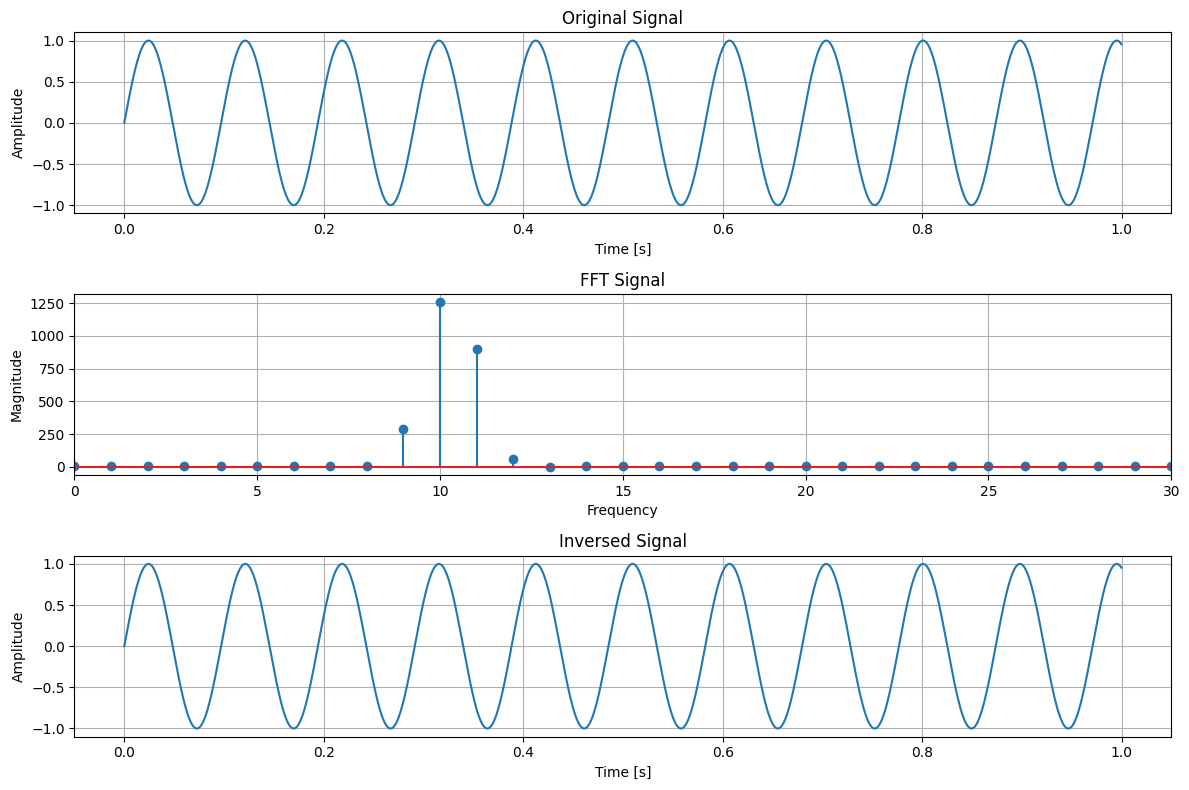

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows, welch

# Generate a sample signal (a sine wave) having an out-of-bins frequency
fs = 5000  # Sampling frequency
t = np.linspace(0, 1, fs, endpoint=False)
print(f"")
original_signal = np.sin(2 * np.pi * 10.1 * t)

# Apply a window function to the noisy signal
window_size = 1024
window = windows.hamming(len(original_signal))
windowed_signal = original_signal * window

# Zero pad the signal for higher FFT resolution
# zero_padded_signal = np.pad(windowed_signal, (0, len(windowed_signal)), 'constant')

# Perform FFT on the windowed and zero-padded signal
signal_fft = np.fft.fft(windowed_signal)
frequencies = np.fft.fftfreq(len(signal_fft), 1/fs)

# Perform IFFT to get the back to the time domain
inversed_signal = np.fft.ifft(signal_fft)
inversed_signal = inversed_signal / window

# Plot the signals
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(t, original_signal, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(3, 1, 2)
plt.stem(frequencies, np.abs(signal_fft), label='FFT on Signal')
plt.title('FFT Signal')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0, 30)
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, inversed_signal[:len(t)].real, label='Inversed Signal (After IFFT)')
plt.title('Inversed Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

plt.tight_layout()
plt.show()


## Sequences of FFT

For a real world use case, we split into multiple frames and apply window per frame. For such a case, accumulate the window used considering the overlaps.

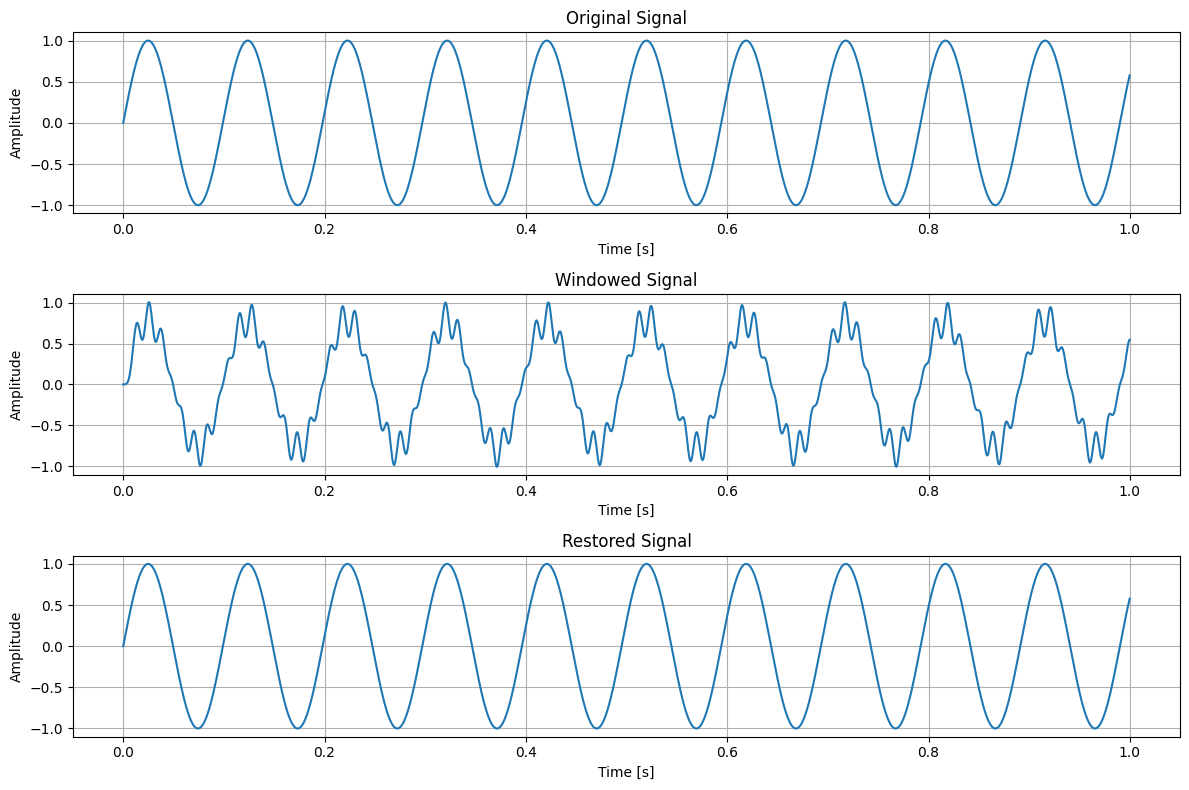

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window

# Generate a sample signal (sine wave with two frequencies)
fs = 5000  # Sampling frequency
t = np.linspace(0, 1, fs, endpoint=False)  # 500 samples
original_signal = np.sin(2 * np.pi * 10.1 * t)

# Parameters for windowing
window_size = 128
overlap = 64
window = get_window('hamming', window_size)

# Pad the original signal to match the window and overlap parameters
pad_length = (window_size - overlap) - (len(original_signal) % (window_size - overlap))
padded_signal = np.pad(original_signal, (0, pad_length), 'constant')

# Number of segments
step = window_size - overlap
num_segments = (len(padded_signal) - overlap) // step

# Initialize arrays to hold FFT results and restored signal
fft_results = np.zeros((num_segments, window_size), dtype=complex)
windowed_signal = np.zeros(len(padded_signal))
window_correction = np.zeros(len(padded_signal))

# Apply window, perform FFT, and overlap-add for restoration
for i in range(num_segments):
    start = i * step
    end = start + window_size
    segment = padded_signal[start:end] * window
    
    # Overlap-add
    windowed_signal[start:end] += segment.real * window
    window_correction[start:end] += window ** 2

# Normalize by the window correction factor
restored_signal = windowed_signal / window_correction
windowed_signal = windowed_signal[:len(original_signal)]

# Remove the padding
restored_signal = restored_signal[:len(original_signal)]

# Plot the original and restored signals
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, original_signal)
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, windowed_signal)
plt.title('Windowed Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, restored_signal)
plt.title('Restored Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

plt.tight_layout()
plt.show()